# SSDF master catalogue
## Preparation of SSDF data

This catalogue comes from `dmu0_SSDF`.

The SSDF data consists in two catalogue of IRAC Ch1 and Ch2 fluxes: one for Ch1 detected sources and the other for Ch2 detected sources. For now, we are only using the Ch1 detected sources. **TODO** : We may find a way to merge the two catalogues and select the best flux for each source.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
04829ed (Thu Nov 2 16:57:19 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "ssdf_ra"
DEC_COL = "ssdf_dec"

## I - Column selection

In [4]:
#To begin lets take the irac_i1 selected sources. Perhaps we should merge in the irac_i2 slected sources.
imported_columns = OrderedDict({
        "cntr": "ssdf_id",
        "ra": "ssdf_ra",
        "dec": "ssdf_dec",
        "class_star": "ssdf_stellarity",
        #"mag_aut1": "m_irac_i1",
        #"magerr_aut1": "merr_irac_i1",
        "flux_aut1": "f_irac_i1",
        "fluxerr_aut1": "ferr_irac_i1",
        #"mag_ap1_4": "m_ap_irac_i1", #Is this a 4 arcsec aperture (corrected) mag?
        #"magerr_ap1_4": "merr_ap_irac_i1",
        "flux_ap1_4": "f_ap_irac_i1",
        "fluxerr_ap1_4": "ferr_ap_irac_i1",
        #"mag_aut2": "m_irac_i2",
        #"magerr_aut2": "merr_irac_i2",
        "flux_aut2": "f_irac_i2",
        "fluxerr_aut2": "ferr_irac_i2",
        #"mag_ap2_4": "m_ap_irac_i2", #Is this a 4 arcsec aperture (corrected) mag?
        #"magerr_ap2_4": "merr_ap_irac_i2",
        "flux_ap2_4": "f_ap_irac_i2",
        "fluxerr_ap2_4": "ferr_ap_irac_i2"
    })


catalogue = Table.read("../../dmu0/dmu0_SSDF/data/SSDF-I1_20160530.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2012 #TODO: Check?

# Clean table metadata
catalogue.meta = None
#catalogue.add_column(Column([str(source) for source in catalogue['ssdf_ra', 'ssdf_dec']], dtype=str), name="ssdf_intid")

In [5]:
# band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        #We compute the magnitudes from the fluxes because the mags are Vega
        mag, error = flux_to_mag(catalogue[col]* 1.e-6, catalogue[errcol] * 1.e-6)
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))

        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

In [6]:
catalogue[:10].show_in_notebook()

idx,ssdf_id,ssdf_ra,ssdf_dec,ssdf_stellarity,f_irac_i1,ferr_irac_i1,f_ap_irac_i1,ferr_ap_irac_i1,f_irac_i2,ferr_irac_i2,f_ap_irac_i2,ferr_ap_irac_i2,m_irac_i1,merr_irac_i1,flag_irac_i1,m_ap_irac_i1,merr_ap_irac_i1,m_irac_i2,merr_irac_i2,flag_irac_i2,m_ap_irac_i2,merr_ap_irac_i2
,,deg,deg,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,
0,1143516,344.83935,-59.774198,0.7,1.48,1.5,nan,nan,nan,nan,nan,nan,23.4743,1.10041,False,nan,nan,nan,nan,False,nan,nan
1,1143796,344.838913,-59.773144,0.65,11.18,2.52,20.11,1.96,nan,nan,nan,nan,21.2789,0.244728,False,20.6415,0.10582,nan,nan,False,nan,nan
2,1143876,344.839952,-59.771165,0.64,1.97,0.98,nan,315.14,nan,nan,nan,nan,23.1638,0.540112,False,nan,nan,nan,nan,False,nan,nan
3,1126474,344.937719,-59.9316,0.09,28.97,2.96,40.24,2.18,1.78,3.58,nan,261.22,20.2451,0.110935,False,19.8884,0.0588197,23.2739,2.18367,False,nan,nan
4,1126450,344.942358,-59.929494,0.27,10.34,2.06,17.96,1.94,12.34,1.9,15.3,1.8,21.3637,0.216307,False,20.7642,0.117279,21.1717,0.167172,False,20.9383,0.127734
5,1126794,344.936402,-59.926379,0.29,8.67,2.22,18.51,1.96,7.57,2.02,11.39,1.76,21.555,0.278009,False,20.7315,0.114967,21.7023,0.289721,False,21.2587,0.16777
6,1127311,344.933348,-59.923402,0.03,21.0,3.2,31.02,2.08,33.6,2.98,24.66,1.92,20.5945,0.165446,False,20.1709,0.0728024,20.0842,0.0962945,False,20.42,0.0845342
7,1127327,344.931642,-59.921819,0.7,26.66,2.7,35.07,2.12,5.02,2.56,1.07,2.24,20.3354,0.109958,False,20.0377,0.0656333,22.1482,0.553682,False,23.8265,2.27294
8,1127176,344.936808,-59.922759,0.87,6.66,1.82,13.19,1.9,20.68,1.76,23.33,1.9,21.8413,0.296703,False,21.0994,0.156399,20.6111,0.0924031,False,20.4802,0.0884226


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['merr_ap_irac_i1',  'merr_ap_irac_i2']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 5488166 sources.
The cleaned catalogue has 5488141 sources (25 removed).
The cleaned catalogue has 25 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_SSDF.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

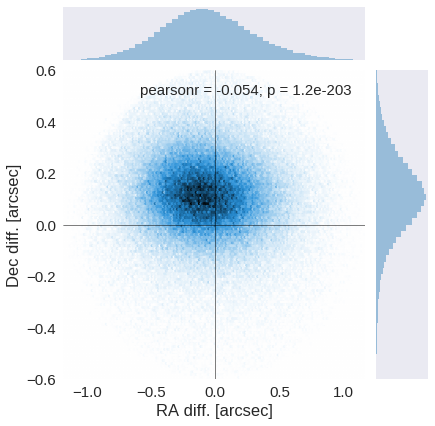

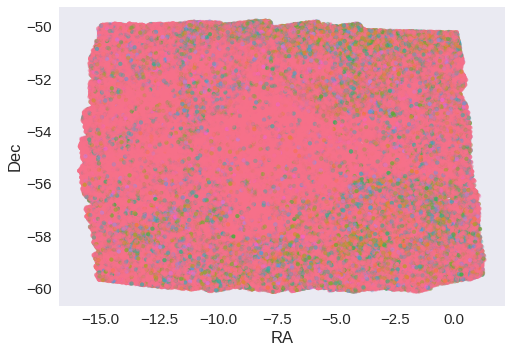

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords, near_ra0=True
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.08155033374350751 arcsec
Dec correction: -0.11236725684966586 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

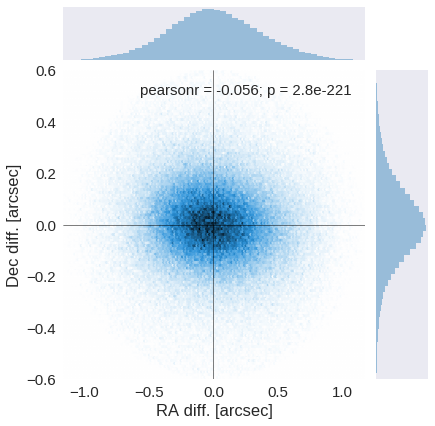

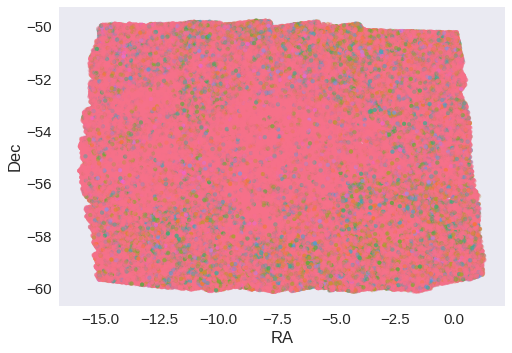

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec, near_ra0=True)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "ssdf_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

352272 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/SSDF.fits".format(OUT_DIR), overwrite=True)